In [1]:
import os
os.chdir("/Users/cornederuijt/github/GCM/") # Adjust after construction of the package

import numpy as np
import pandas as pd
import pickle as pl
from plotnine import *
from scripts.clickmodel_fitters.clickdefinitionreader import ClickDefinition
from scripts.clickmodel_fitters.GCM import GCM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import Zeros
from scipy.linalg import norm
from copy import deepcopy

np.random.seed(1992)

In [2]:
# Define the model

list_size = 10
no_states = 7
click_states = np.zeros((no_states, list_size + 1))
click_states[3, :] = 1
abs_state = [(i, 6) for i in range(7)]
init_state = 3  # Equals the click state
batch_size = 10000
no_items = 100

var_dic = {
    'gamma': {
        'var_type': 'session',
        't0_fixed': 1,  # Always continues to evaluate the first item
        'pos_mat': np.vstack((np.zeros((2, no_states)),
                              np.array([0, 0, 1, 1, 0, 0, 0]),
                              np.array([0, 0, 1, 1, 0, 0, 0]),
                              np.zeros((3, no_states)))),
        'neg_mat': np.vstack((np.zeros((2, no_states)),
                              np.array([1, 1, 0, 0, 0, 0, 0]),
                              np.array([1, 1, 0, 0, 0, 0, 0]),
                              np.zeros((3, no_states)))),
        'fixed_mat': np.vstack((np.zeros((3, no_states)),
                                np.array([0, 0, 0, 0, 1, 1, 0]),
                                np.zeros((3, no_states))))
    },
    'phi_S': {
        'var_type': 'item',
        't0_fixed': 0,  # Never satisfied in the first state
        'pos_mat': np.vstack((np.zeros((3, no_states)),
                              np.array([0, 0, 0, 0, 1, 1, 0]),
                              np.zeros((3, no_states)))),
        'neg_mat': np.vstack((np.zeros((3, no_states)),
                              np.array([1, 1, 1, 1, 0, 0, 0]),
                              np.zeros((3, no_states)))),
        'fixed_mat': np.vstack((np.zeros((2, no_states)),
                                np.array([1, 1, 1, 1, 0, 0, 0]),
                                np.zeros((4, no_states))))
    },
    'phi_A': {
        'var_type': 'item',
        'pos_mat': np.vstack((np.zeros((2, no_states)),
                              np.array([0, 1, 0, 1, 0, 0, 0]),
                              np.array([0, 1, 0, 1, 0, 1, 0]),
                              np.zeros((3, no_states)))),
        'neg_mat': np.vstack((np.zeros((2, no_states)),
                              np.array([1, 0, 1, 0, 0, 0, 0]),
                              np.array([1, 0, 1, 0, 1, 0, 0]),
                              np.zeros((3, no_states))))
    }
}

model_def = ClickDefinition(click_states, init_state, list_size, no_states, batch_size, no_items, abs_state,
                            var_dic)

In [3]:
# Load data:
click_data = pd.read_csv("./data/small_example/simulation_res_train.csv", index_col=False)
prod_position = pd.read_csv("./data/small_example/simulation_item_props.csv", index_col=False)

    
# Ensure the order is correct:
click_data = click_data.sort_values(['user_id', 'session_count', 'item_order'])
    
# Add session index:
session_index = (click_data
                 .loc[:, ['user_id', 'session_count']] 
                 .drop_duplicates() 
                 .reset_index()
                )

session_index['session'] = session_index.index.to_numpy()

click_data = (click_data 
    .set_index(['user_id', 'session_count']) 
    .join(session_index
          .set_index(['user_id', 'session_count']),
          on=['user_id', 'session_count']) 
    .reset_index()
    .set_index('item')
    .join(prod_position
         .set_index('item'),
         on='item')
    .reset_index()
)

click_data

    

,item,user_id,session_count,item_order,click,attr,satis,eval,orig_list_id,index,session,X0,X1
0,42,0,0,1,0.0,0,0,1.0,0,0,0,-0.617880,-0.424150
1,66,0,0,2,0.0,0,0,1.0,0,0,0,-0.463804,-0.667938
2,89,0,0,3,0.0,0,0,1.0,0,0,0,-0.849402,1.813430
3,64,0,0,4,0.0,0,0,1.0,0,0,0,-1.875517,-1.026840
4,25,0,0,5,0.0,0,0,1.0,0,0,0,-0.908807,0.050236
...,...,...,...,...,...,...,...,...,...,...,...,...,...
250565,85,17999,2,6,0.0,0,0,0.0,35807,250560,25056,-0.362179,-0.737943
250566,3,17999,2,7,0.0,1,0,0.0,35807,250560,25056,0.136692,0.039374
250567,76,17999,2,8,0.0,1,0,0.0,35807,250560,25056,0.257214,-0.653226
250568,64,17999,2,9,0.0,0,0,0.0,35807,250560,25056,-1.875517,-1.026840


In [4]:
# Create the click matrix and item position matrix
click_mat = click_data.loc[:, ['session', 'item_order', 'click']] \
    .pivot(index='session', columns='item_order', values='click') \
    .to_numpy()

item_pos_mat = click_data.loc[:, ['session', 'item_order', 'item']] \
    .pivot(index='session', columns='item_order', values='item') \
    .to_numpy()

In [5]:
# Create feature matrix for phi_A, phi_S and gamma
item_feature_mat_A = (click_data.loc[:, ['item', 'X0', 'X1']] 
                                .drop_duplicates() 
                                .sort_values('item')
                                .to_numpy()
                     )
item_feature_mat_S = deepcopy(item_feature_mat_A)

n_sessions = click_data['session'].nunique()
gamma_feature_mat = np.ones((n_sessions, 1))

In [6]:
# Define the Keras models
model_phi_A = Sequential()
model_phi_A.add(Dense(1, input_dim=item_feature_mat_A.shape[1], activation='sigmoid', use_bias=False,
                     kernel_initializer=Zeros()))
model_phi_A.compile(loss=GCM.pos_log_loss, optimizer=RMSprop())

model_phi_S = Sequential()
model_phi_S.add(Dense(1, input_dim=item_feature_mat_S.shape[1], activation='sigmoid', use_bias=False,
                     kernel_initializer=Zeros()))
model_phi_S.compile(loss=GCM.pos_log_loss, optimizer=RMSprop())

model_gamma = Sequential()
model_gamma.add(Dense(1, input_dim=gamma_feature_mat.shape[1], activation='sigmoid', use_bias=False,
                     kernel_initializer=Zeros()))
model_gamma.compile(loss=GCM.pos_log_loss, optimizer=RMSprop())


var_dic = {'phi_A': item_feature_mat_A, 'phi_S': item_feature_mat_S, 'gamma': gamma_feature_mat}
var_models = {'phi_A': model_phi_A, 'phi_S': model_phi_S, 'gamma': model_gamma}

In [7]:
# Run model
res = GCM.runEM(click_mat, var_dic, var_models, item_pos_mat, model_def, verbose=True)


Iteration: 0
Running E-step ...
Current conditional entropy:0.36116
Running M-step ...
Epoch 1/250
1/1 [==============================] - 0s 669us/step - loss: 3473638.5000
Epoch 2/250
1/1 [==============================] - 0s 539us/step - loss: 3444189.0000
Epoch 3/250
1/1 [==============================] - 0s 702us/step - loss: 3443152.7500
Epoch 4/250
1/1 [==============================] - 0s 490us/step - loss: 3443073.0000
Epoch 5/250
1/1 [==============================] - 0s 515us/step - loss: 3443037.7500
Epoch 6/250
1/1 [==============================] - 0s 614us/step - loss: 3443013.0000
Epoch 7/250
1/1 [==============================] - 0s 600us/step - loss: 3442994.2500
Epoch 8/250
1/1 [==============================] - 0s 499us/step - loss: 3442980.5000
Epoch 9/250
1/1 [==============================] - 0s 576us/step - loss: 3442968.7500
Epoch 10/250
1/1 [==============================] - 0s 503us/step - loss: 3442960.0000
Epoch 11/250
1/1 [==============================] - 

1/1 [==============================] - 0s 630us/step - loss: 2908382.5000
Epoch 63/250
1/1 [==============================] - 0s 529us/step - loss: 2908358.0000
Epoch 64/250
1/1 [==============================] - 0s 587us/step - loss: 2908335.0000
Epoch 65/250
1/1 [==============================] - 0s 518us/step - loss: 2908311.7500
Epoch 66/250
1/1 [==============================] - 0s 593us/step - loss: 2908290.0000
Epoch 67/250
1/1 [==============================] - 0s 605us/step - loss: 2908269.0000
Epoch 68/250
1/1 [==============================] - 0s 701us/step - loss: 2908248.7500
Epoch 69/250
1/1 [==============================] - 0s 629us/step - loss: 2908229.0000
Epoch 70/250
1/1 [==============================] - 0s 647us/step - loss: 2908210.2500
Epoch 71/250
1/1 [==============================] - 0s 528us/step - loss: 2908192.2500
Epoch 72/250
1/1 [==============================] - 0s 584us/step - loss: 2908174.5000
Epoch 73/250
1/1 [==============================] - 0s 6

7/7 [==============================] - 2s 339ms/step - loss: 19311646.0000
Epoch 65/250
7/7 [==============================] - 2s 322ms/step - loss: 19258092.0000
Epoch 66/250
7/7 [==============================] - 2s 328ms/step - loss: 19213430.0000
Epoch 67/250
7/7 [==============================] - 2s 326ms/step - loss: 19170832.0000
Epoch 68/250
7/7 [==============================] - 2s 340ms/step - loss: 19123898.0000
Epoch 69/250
7/7 [==============================] - 2s 331ms/step - loss: 19082342.0000
Epoch 70/250
7/7 [==============================] - 2s 339ms/step - loss: 19042158.0000
Epoch 71/250
7/7 [==============================] - 2s 327ms/step - loss: 19009082.0000
Epoch 72/250
7/7 [==============================] - 2s 332ms/step - loss: 18965854.0000
Epoch 73/250
7/7 [==============================] - 2s 335ms/step - loss: 18932878.0000
Epoch 74/250
7/7 [==============================] - 2s 335ms/step - loss: 18876120.0000
Epoch 75/250
7/7 [===========================

7/7 [==============================] - 2s 335ms/step - loss: 16600565.0000
Epoch 157/250
7/7 [==============================] - 2s 322ms/step - loss: 16585299.0000
Epoch 158/250
7/7 [==============================] - 2s 342ms/step - loss: 16564248.0000
Epoch 159/250
7/7 [==============================] - 2s 353ms/step - loss: 16548451.0000
Epoch 160/250
7/7 [==============================] - 2s 343ms/step - loss: 16537464.0000
Epoch 161/250
7/7 [==============================] - 2s 333ms/step - loss: 16528587.0000
Epoch 162/250
7/7 [==============================] - 2s 332ms/step - loss: 16515700.0000
Epoch 163/250
7/7 [==============================] - 2s 329ms/step - loss: 16498260.0000
Epoch 164/250
7/7 [==============================] - 2s 336ms/step - loss: 16478247.0000
Epoch 165/250
7/7 [==============================] - 2s 340ms/step - loss: 16470453.0000
Epoch 166/250
7/7 [==============================] - 2s 341ms/step - loss: 16455478.0000
Epoch 167/250
7/7 [================

1/1 [==============================] - 0s 578us/step - loss: 3451290.0000
Epoch 7/250
1/1 [==============================] - 0s 503us/step - loss: 3451216.7500
Epoch 8/250
1/1 [==============================] - 0s 567us/step - loss: 3451190.5000
Epoch 9/250
1/1 [==============================] - 0s 515us/step - loss: 3451180.5000
Epoch 10/250
1/1 [==============================] - 0s 589us/step - loss: 3451177.5000
Epoch 11/250
1/1 [==============================] - 0s 499us/step - loss: 3451178.5000
Epoch 12/250
1/1 [==============================] - 0s 548us/step - loss: 3451184.7500
Epoch 13/250
1/1 [==============================] - 0s 488us/step - loss: 3451198.0000
Epoch 14/250
1/1 [==============================] - 0s 556us/step - loss: 3451231.0000
Epoch 15/250
1/1 [==============================] - 0s 581us/step - loss: 3451310.7500
Epoch 1/250
1/1 [==============================] - 0s 776us/step - loss: 2824262.0000
Epoch 2/250
1/1 [==============================] - 0s 542us/

1/1 [==============================] - 0s 499us/step - loss: 2773250.0000
Epoch 13/250
1/1 [==============================] - 0s 726us/step - loss: 2773299.7500
Epoch 14/250
1/1 [==============================] - 0s 530us/step - loss: 2773386.0000
Epoch 15/250
1/1 [==============================] - 0s 619us/step - loss: 2773478.5000
Epoch 1/250
7/7 [==============================] - 2s 350ms/step - loss: 16161754.0000
Epoch 2/250
7/7 [==============================] - 2s 356ms/step - loss: 16162497.0000
Epoch 3/250
7/7 [==============================] - 3s 357ms/step - loss: 16158745.0000
Epoch 4/250
7/7 [==============================] - 2s 345ms/step - loss: 16156316.0000
Epoch 5/250
7/7 [==============================] - 2s 347ms/step - loss: 16162486.0000
Epoch 6/250
7/7 [==============================] - 2s 348ms/step - loss: 16167190.0000
Epoch 7/250
7/7 [==============================] - 3s 360ms/step - loss: 16167752.0000
Epoch 8/250
7/7 [==============================] - 3s 36

1/1 [==============================] - 0s 557us/step - loss: 2753070.7500
Epoch 5/250
1/1 [==============================] - 0s 591us/step - loss: 2753070.5000
Epoch 6/250
1/1 [==============================] - 0s 615us/step - loss: 2753083.0000
Epoch 7/250
1/1 [==============================] - 0s 611us/step - loss: 2753109.7500
Epoch 8/250
1/1 [==============================] - 0s 515us/step - loss: 2753166.0000
Epoch 9/250
1/1 [==============================] - 0s 567us/step - loss: 2753257.5000
Epoch 10/250
1/1 [==============================] - 0s 534us/step - loss: 2753405.7500
Epoch 1/250
7/7 [==============================] - 2s 347ms/step - loss: 16272369.0000
Epoch 2/250
7/7 [==============================] - 3s 368ms/step - loss: 16278687.0000
Epoch 3/250
7/7 [==============================] - 3s 360ms/step - loss: 16280545.0000
Epoch 4/250
7/7 [==============================] - 3s 362ms/step - loss: 16280736.0000
Epoch 5/250
7/7 [==============================] - 2s 351ms/s

In [8]:
pl.dump(res[1:3], open("./results/czm_res.pl", 'wb')) # Don't want to store final model, best model already stored

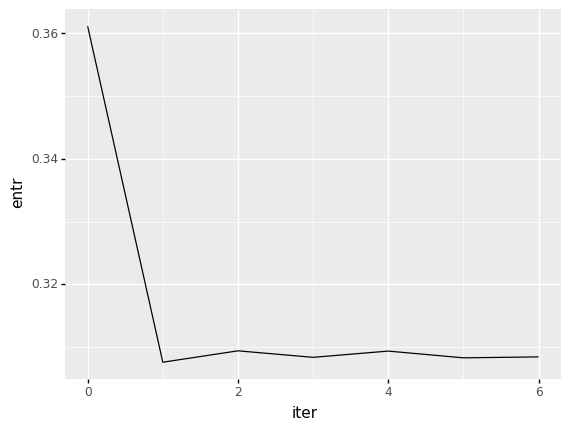

<ggplot: (8773955829495)>

In [9]:
(ggplot(pd.DataFrame(np.hstack((np.arange(len(res[2])).reshape(-1, 1), np.array(res[2]).reshape(-1 ,1))),
            columns=['iter', 'entr'])) +
 geom_line(aes(x='iter', y='entr'))
)


In [10]:
# Combine the results:
phi_A_all = []
phi_S_all = []
gamma_all = []
for param_val in res[1]:
    phi_A_all.append(param_val['phi_A'].reshape(-1, 1))
    phi_S_all.append(param_val['phi_S'].reshape(-1, 1))
    gamma_all.append(param_val['gamma'][0])

phi_A_mat = np.hstack(phi_A_all)
phi_S_mat = np.hstack(phi_S_all)
gamma_mat = np.hstack(gamma_all)

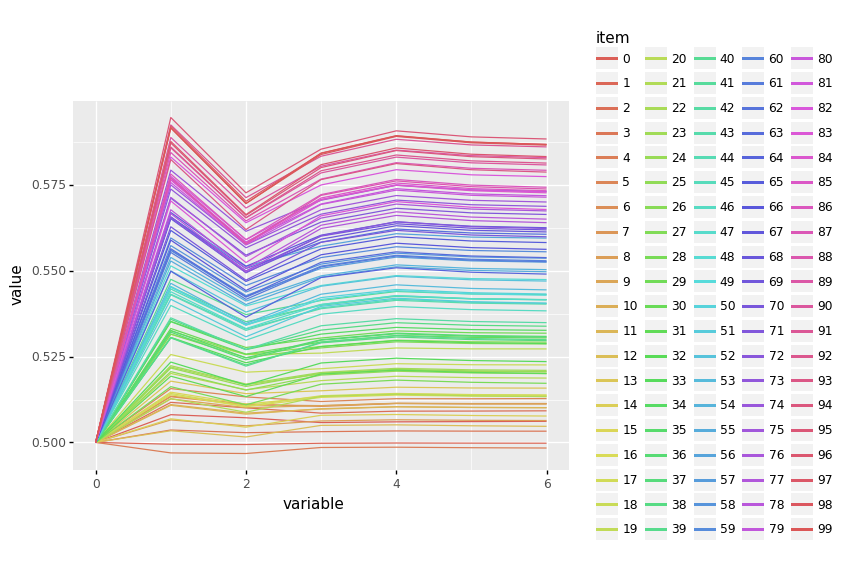

<ggplot: (8773615217619)>

In [11]:
phi_A_pd = pd.DataFrame(phi_A_mat)
phi_A_pd['item'] = np.arange(phi_A_pd.shape[0])
phi_A_pd = pd.melt(phi_A_pd, id_vars=['item'])
phi_A_pd['variable'] = phi_A_pd['variable'].astype(float)
phi_A_pd['item'] = phi_A_pd['item'].astype('category')

(ggplot(phi_A_pd) +
geom_line(aes(x='variable', y='value', color='item'))
)

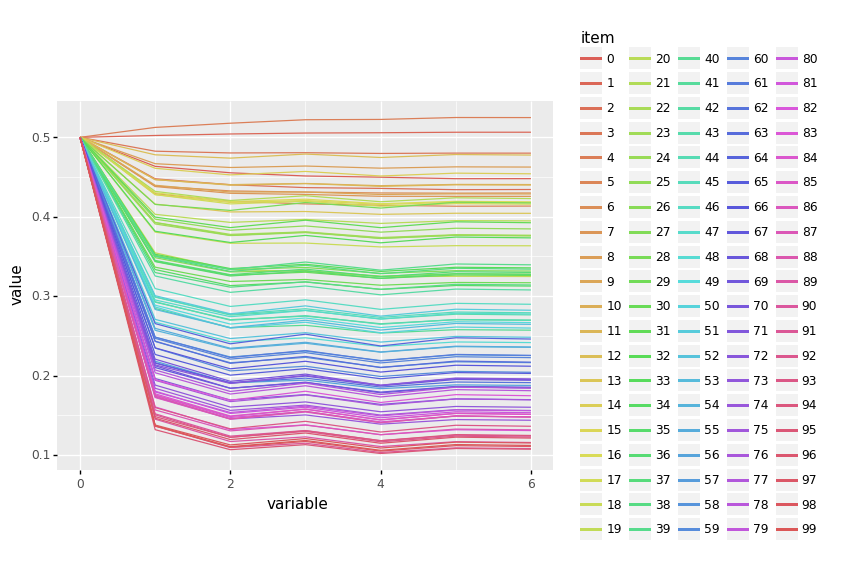

<ggplot: (8773202205154)>

In [12]:
phi_S_pd = pd.DataFrame(phi_S_mat)
phi_S_pd['item'] = np.arange(phi_S_pd.shape[0])
phi_S_pd = pd.melt(phi_S_pd, id_vars=['item'])
phi_S_pd['variable'] = phi_S_pd['variable'].astype(float)
phi_S_pd['item'] = phi_S_pd['item'].astype('category')

(ggplot(phi_S_pd) +
geom_line(aes(x='variable', y='value', color='item'))
)

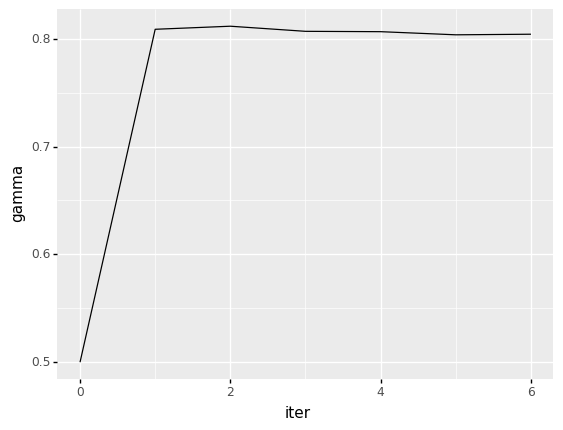

<ggplot: (8773722442614)>

In [13]:
(ggplot(pd.DataFrame(np.hstack((np.arange(gamma_mat.shape[0]).reshape(-1, 1), gamma_mat.reshape(-1 ,1))),
            columns=['iter', 'gamma'])) +
 geom_line(aes(x='iter', y='gamma'))
)



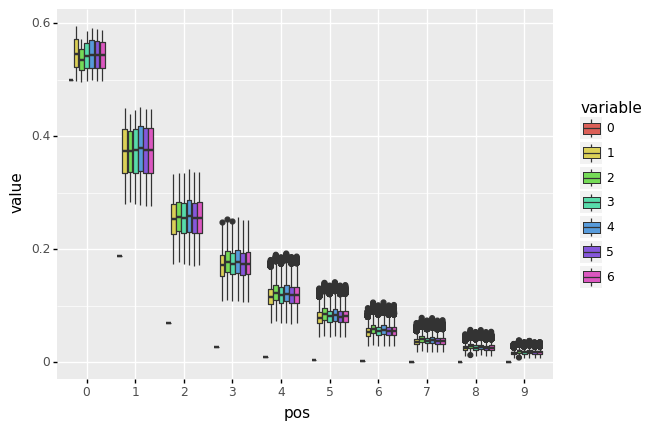

<ggplot: (8773698082292)>

In [14]:
click_probs = [prob.reshape(-1, 1) for prob in res[3]]
click_probs_pd = pd.DataFrame(np.hstack(click_probs))
click_probs_pd['pos'] = np.tile(np.arange(10), int(click_probs_pd.shape[0]/10))
click_probs_pd['pos'] = click_probs_pd['pos'].astype('category')
click_probs_pd

click_probs_pd_flat = pd.melt(click_probs_pd, id_vars=['pos'])
click_probs_pd_flat['variable'] = click_probs_pd_flat['variable'].astype('category')

(ggplot(click_probs_pd_flat) +
 geom_boxplot(aes(x='pos', y='value', fill='variable'))
)



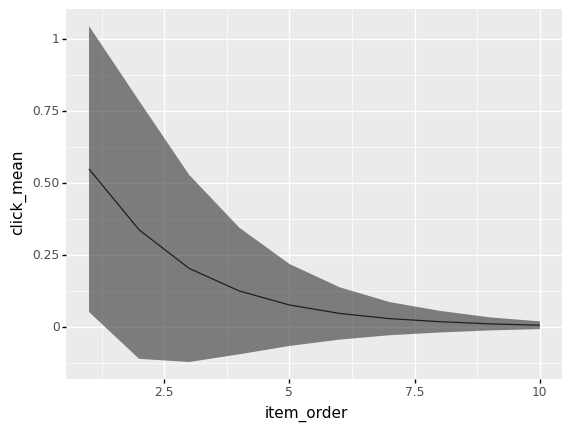

<ggplot: (8773698087048)>

In [15]:
def flatten_index(df):
  df_copy = df.copy()
  df_copy.columns = ['_'.join(col).rstrip('_') for col in df_copy.columns.values]
  return df_copy.reset_index()

real_click = click_data
real_click['item_order'] = real_click['item_order'].astype('int')

res = real_click.groupby(['item_order']).agg({'click': ['mean', 'var']}).pipe(flatten_index)
res
res['upper'] = res['click_mean'] + 2*res['click_var']
res['lower'] = res['click_mean'] - 2*res['click_var']

(ggplot(res)+
 geom_line(aes(x='item_order', y='click_mean')) +
 geom_ribbon(aes(x='item_order', ymin='lower', ymax='upper'), alpha = 0.6)
)

In [ ]:
# def flatten_index(df):
#   df_copy = df.copy()
#   df_copy.columns = ['_'.join(col).rstrip('_') for col in df_copy.columns.values]
#   return df_copy.reset_index()

# # Perplexity on the different positions

# real_click_vec = real_click['click'].to_numpy()
# pos_entr = []
# neg_entr = []

# i = 0
# for cp in click_probs:
#     pos_entr.append((-real_click_vec * np.log(cp)).reshape(-1, 1))
#     neg_entr.append((-(1 - real_click_vec) * np.log(1 - cp)).reshape(-1, 1))

# pos_entr_full = pd.DataFrame(np.hstack((pos_entr)))
# pos_entr_full['pos'] = np.tile(np.arange(10), int(pos_entr_full.shape[0]/10))

# neg_entr_full = pd.DataFrame(np.hstack((pos_entr)))
# neg_entr_full['pos'] = np.tile(np.arange(10), int(pos_entr_full.shape[0]/10))

# pos_entr_pd_plot = pd.melt(pos_entr_full,id_vars=['pos']).groupby(['pos', 'variable']).agg({'value': 'mean'}).\
#     pipe(flatten_index)
# pos_entr_pd_plot = pos_entr_pd_plot.rename(columns={'v_a_l_u_e': 'value'})
# pos_entr_pd_plot['pos'] = pos_entr_pd_plot['pos'].astype('int')
# pos_entr_pd_plot['variable'] = pos_entr_pd_plot['variable'].astype('category')

# pos_entr_pd_plot.pivot(index='pos', columns='variable', values='value')
# #pos_entr_pd_plot.pivot('variable')